### Init

In [123]:
from utility import *
from BFIClasses import *
from Simulation import *
from math_primitives.NumericStepFunctions import *
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from time import process_time, sleep

In [77]:
class ExecutionTimer:
    
    global_timer = None
    
    def __init__(self, silent=False):
        self.start_time = None
        self.end_time = None
        self.elapsed = None
        self.silent = silent
        
    def tic(self):
        self.start_time = process_time()
        
    def toc(self):
        self.end_time = process_time()
        self.elapsed = self.end_time - self.start_time
        
        if not self.silent:
            print(f"Time elapsed: {self.elapsed}")
            
        return self.elapsed
            
def tic():
    ExecutionTimer.global_timer = ExecutionTimer()
    ExecutionTimer.global_timer.tic()
    
def toc():
    if ExecutionTimer.global_timer is None:
        raise AttributeError("No global timer is currently running. Call toc() first.")
    res = ExecutionTimer.global_timer.toc()
    ExecutionTimer.global_timer = None
    return res

In [78]:
# test 1: ring of 4 balls with gravity
def test1(r=100, g=1e7, sps=100, method=lambda: Euler()):
    v = np.sqrt((1+2*np.sqrt(2))*(g/r))/2

    sim = Simulation(
        start_balls=[
            make_ball(r * Vector([0, -1]), v * Vector([1, 0]),  start_dv=v**2/r * Vector([0, 1])),
            make_ball(r * Vector([0, 1]),  v * Vector([-1, 0]), start_dv=v**2/r * Vector([0, -1])),
            make_ball(r * Vector([1, 0]),  v * Vector([0, 1]),  start_dv=v**2/r * Vector([-1, 0])),
            make_ball(r * Vector([-1, 0]), v * Vector([0, -1]), start_dv=v**2/r * Vector([1, 0]))
        ],
        fields={},
        interactions=[Interaction("gravity", ("Ball", "Ball"),
                                  formula=lambda target, source:
                                  g/(Ball.distance(target[0], source)**2) * target[0].direction(source),
                                  attribute="velocity"
                                  )],
        total_time=5, steps_per_second=sps, field_size=(1000, 600))
    
    return sim

# test 2: 2 balls on spring
def test2(l=100, k=1, sps=100, method=lambda: Euler()):

    start_center = Vector([-300, 0])
    lin_v = Vector([50, 0])
    spin_v = Vector([80, 0])

    sim = Simulation(
        start_balls=[
            make_ball(l/2 * Vector([0, -1]) + start_center, lin_v + spin_v, step_func=method),
            make_ball(l/2 * Vector([0, 1]) + start_center, lin_v - spin_v, step_func=method)
        ],
        fields={},
        interactions=[Interaction("spring", ("Ball", "Ball"),
                                  formula=lambda target, source:
                                  k * Ball.distance(target[0], source) * target[0].direction(source),
                                  attribute="velocity"
                                  )],
        total_time=10, steps_per_second=sps, field_size=(1000, 600))
    
    return sim

# test 3: sinusoidal ball (no field)
def test3(v=50, r=100, k=1, sps=100, method=lambda: Euler()):

    sim = Simulation(
        start_balls=[
            make_ball(r * Vector([0, -1]) + Vector([-300, 0]), v * Vector([1, 0]), step_func=method)
        ],
        fields={},
        interactions=[Interaction("sinusoidal", ("Ball", "Self"),
                                  formula=lambda target, _:
                                  k * target[0].position.current.y * Vector([0, -1]),
                                  attribute="velocity"
                                  )],
        total_time=10, steps_per_second=sps, field_size=(1000, 600))
    
    return sim

# test 4: sinusoidal ball (with field)
def test4(v=50, r=100, k=1, sps=100, fres=20, method=lambda: Euler()):

    fsize = (1000, 1000)
    
    sim = Simulation(
        start_balls=[
            make_ball(r * Vector([0, 1]) + Vector([-300, 0]), v * Vector([1, 0]), step_func=method)
        ],
        fields={"sinusoidal": make_field("sinusoidal", size=fsize, res=(fres, fres),
                                        func=lambda x, y: x, const=True)},
        interactions=[Interaction("sinusoidal", ("Ball", "sinusoidal"),
                                  formula=lambda target, field:
                                  k * field.value(target[0].position.current) * Vector([0, -1]),
                                  attribute="velocity"
                                  )],
        total_time=10, steps_per_second=sps, field_size=fsize, border_effect="ignore")
    
    return sim

### TEST 2

In [10]:
sim = test2(k=((80/50)**2)/2, sps=1000, method=lambda: Euler())
sim.simulate()

In [11]:
ball1 = sim.balls[0]
ball2 = sim.balls[1]

t = np.linspace(0, 10, 1000)
pos1_x = [ball1.position.val(t_v).x for t_v in t]
pos1_y = [ball1.position.val(t_v).y for t_v in t]
pos2_x = [ball2.position.val(t_v).x for t_v in t]
pos2_y = [ball2.position.val(t_v).y for t_v in t]

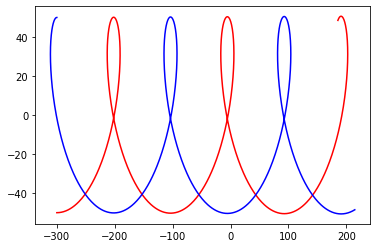

In [12]:
plt.plot(pos1_x, pos1_y, 'r-', pos2_x, pos2_y, 'b-')
plt.show()

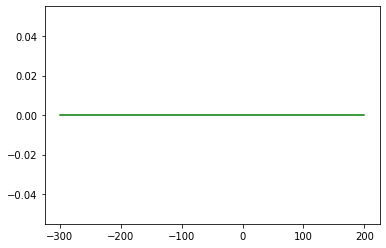

max(center_mass.y)=0.0, min(center_mass.y)=0.0


In [13]:
# Mass center
cm_x = [(p1 + p2)/2 for (p1, p2) in zip(pos1_x, pos2_x)]
cm_y = [(p1 + p2)/2 for (p1, p2) in zip(pos1_y, pos2_y)]

plt.plot(cm_x, cm_y, 'g-')
plt.show()

print(f"max(center_mass.y)={max(cm_y)}, min(center_mass.y)={min(cm_y)}")

In [14]:
print(f"start_pos=({cm_x[0]}, {cm_y[0]}) --> end_pos=({cm_x[-1]}, {cm_y[-1]})")
print(f"distance: {np.sqrt((cm_x[0] - cm_x[-1])**2 + (cm_y[0] - cm_y[-1])**2)}")

start_pos=(-300.0, 0.0) --> end_pos=(199.99999999999875, 0.0)
distance: 499.99999999999875


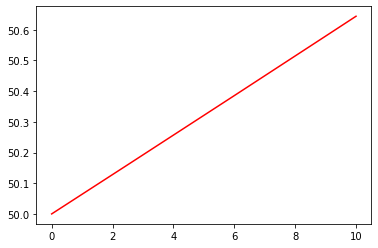

In [15]:
# Radius
r1 = [np.sqrt((px-cx)**2 + (py-cy)**2) for (px, py, cx, cy) in zip(pos1_x, pos1_y, cm_x, cm_y)]
r2 = [np.sqrt((px-cx)**2 + (py-cy)**2) for (px, py, cx, cy) in zip(pos2_x, pos2_y, cm_x, cm_y)]
plt.plot(t, r1, 'r-')

### TEST 3

In [16]:
sps=600
sim = test3(sps=sps, method=lambda: Method3212())
sim.simulate()

In [17]:
ball = sim.balls[0]

In [18]:
t = np.linspace(0, 10, 1000)
t_c = np.linspace(0, 10, 10*sps)

# actual
x = [ball.position.val(t_v).x for t_v in t_c]
y = [ball.position.val(t_v).y for t_v in t_c]

# expected
xc = np.linspace(-300, -300 + 50*10, 1000)
yc = -100*np.cos(t)

# coarse expected
xc_c = np.linspace(-300, -300 + 50*10, 10*sps)
yc_c = -100*np.cos(t_c)

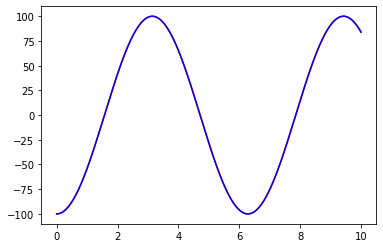

In [19]:
max_i = 1000
plt.plot(t_c[:int(max_i/100*sps)], y[:int(max_i/100*sps)], 'r-', t[:max_i], yc[:max_i], 'b-')
plt.show()

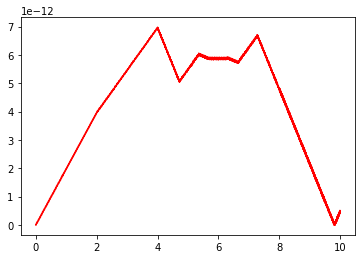

In [20]:
max_i = 1000
plt.plot(t_c[:int(max_i/100*sps)], [abs(a-e) for (a, e) in zip(x[:int(max_i/100*sps)], xc_c[:int(max_i/100*sps)],)], 'r-')
plt.show()

In [21]:
error = [abs(y_v - yc_v) for (y_v, yc_v) in zip(y, yc_c)]

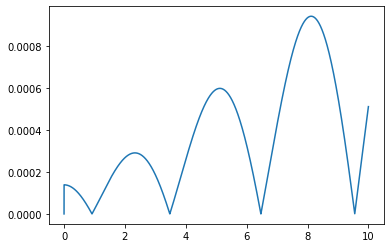

In [22]:
plt.plot(t_c, error)

### TEST 3: Convergence exponent

In [23]:
# convergence exponent (Euler)
tic()

res_e = []
n_e = list(range(10, 400, 10))
for i in n_e:
    sim = test3(sps=i, method=lambda: Euler())
    sim.simulate()
    
    t_c = [tv.time for tv in sim.balls[0].position.values]
    yc_c = -100*np.cos(np.array(t_c))
    y = [tv.val.y for tv in sim.balls[0].position.values]
    error = [abs(y_v - yc_v) for (y_v, yc_v) in zip(y, yc_c)]
    res_e.append(max(error))
    
toc()

Time elapsed: 46.59375


46.59375

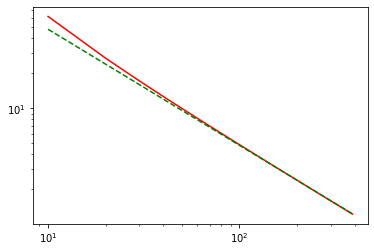

In [43]:
plt.loglog(n_e, res_e, 'r-', n_e, [480*k**(-1) for k in n_e], 'g--')

In [21]:
# convergence exponent (Method 3/2-1/2)
tic()

res_m = []
n_m = list(range(10, 400, 10))
for i in n_m:
    sim = test3(sps=i, method=lambda: Method3212())
    sim.simulate()
    
    t_c = [tv.time for tv in sim.balls[0].position.values]
    yc_c = -100*np.cos(np.array(t_c))
    y = [tv.val.y for tv in sim.balls[0].position.values]
    error = [abs(y_v - yc_v) for (y_v, yc_v) in zip(y, yc_c)]
    res_m.append(max(error))
    
toc()

Time elapsed: 48.328125


48.328125

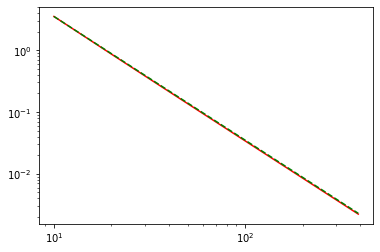

In [22]:
plt.loglog(n_m, res_m, 'r-', n_m, [350*k**(-2) for k in n_m], 'g--')

In [25]:
# convergence exponent (Adams-Bashford)
tic()

res_ab = []
n_ab = list(range(10, 400, 10))
for i in n_ab:
    sim = test3(sps=i, method=lambda: AdamsBashford5())
    sim.simulate()
    
    t_c = [tv.time for tv in sim.balls[0].position.values]
    yc_c = -100*np.cos(np.array(t_c))
    y = [tv.val.y for tv in sim.balls[0].position.values]
    error = [abs(y_v - yc_v) for (y_v, yc_v) in zip(y, yc_c)]
    res_ab.append(max(error))
    
toc()

Time elapsed: 49.484375


49.484375

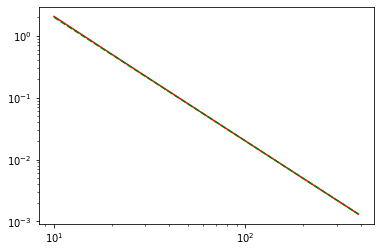

In [42]:
plt.loglog(n_ab, res_ab, 'r-', n_ab, [200*k**(-2) for k in n_ab], 'g--')

In [27]:
# convergence exponent (Adams-Moulton)
tic()

res_am = []
n_am = list(range(10, 400, 10))
for i in n_am:
    sim = test3(sps=i, method=lambda: AdamsMoulton5())
    sim.simulate()
    
    t_c = [tv.time for tv in sim.balls[0].position.values]
    yc_c = -100*np.cos(np.array(t_c))
    y = [tv.val.y for tv in sim.balls[0].position.values]
    error = [abs(y_v - yc_v) for (y_v, yc_v) in zip(y, yc_c)]
    res_am.append(max(error))
    
toc()

Time elapsed: 48.328125


48.328125

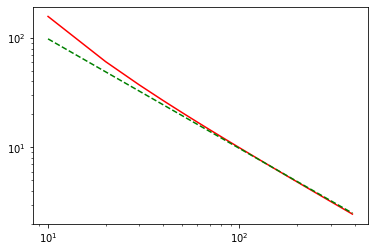

In [37]:
plt.loglog(n_am, res_am, 'r-', n_am, [980*k**(-1) for k in n_am], 'g--')

### Manual partial tests

In [79]:
# Manual test
def manual_test_1(steps=100, k=1, r=1, max_t=10, method=Euler):

    values = [TimedVal(r, 0)]
    dv = [TimedVal(0, 0)] # ???

    def f(v, t):
        return -k*v

    step_func = method()
    time = np.linspace(0, max_t, steps)
    for i in range(1, len(time)):
        t = time[i]
        dv.append(TimedVal(time=t, val=f(values[-1].val, t)))
        values.append(TimedVal(time=t, val=values[-1].val + step_func(dv)))

    v = [val.val for val in values]
    vc = r*np.exp(-k*time)
    
    return v, vc, time

In [80]:
# Manual test with PrimaryData
def primarydata_test_1(steps=100, k=1, r=1, max_t=10, method=Euler):
    
    values = PrimaryDataNumeric(float, step_func=method(), initial=r)
    
    def f(v, t):
        return -k*v
    
    time = np.linspace(0, max_t, steps)
    for i in range(1, len(time)):
        values.add_derivative((time[i], f(values.current, time[i])))
        values.collapse_last_val()
        
    v = [val.val for val in values.values]
    vc = r*np.exp(-k*time)
    
    return v, vc, time

In [81]:
# Manual test with Ball
def ball_test_1(steps=100, k=1, r=1, max_t=10, method=Euler):
    
    ball = make_ball(Vector([r, 0]), Vector([0, 0]), step_func=method)
    
    def f(pos, t):
        return -k*pos
    
    time = np.linspace(0, max_t, steps)
    for i in range(1, len(time)):
        ball.velocity.add_derivative((time[i], f(ball.position.current, time[i])))
        ball.update(time[i])
        
    v = [tv.val.x for tv in ball.position.values]
    vc = r*np.cos(np.sqrt(k)*time)
    
    return v, vc, time

In [82]:
# Manual test with Sim
def sim_test_1(steps=100, k=1, r=1, method=Method3212):
    
    sim = test4(r=r, k=k, sps=steps, method=method)
    sim.simulate()
    
    v = [tv.val.y for tv in sim.balls[0].position.values]
    time = np.array([tv.time for tv in sim.balls[0].position.values])
    vc = r*np.cos(np.sqrt(k)*time)
    
    return v, vc, time

In [49]:
# Time error (should be 0)
sim = test3(sps=100, method=Euler)
sim.simulate()
err = abs(sim.time - sim.total_time)
print(f"error = {err} (relative: {err/sim.dt})")

error = 0.0 (relative: 0.0)


In [51]:
test = sim_test_1
max_n = 200

# Test methods with different step sizes
methods = [
           ("Euler", Euler), 
           ("Method3212", Method3212), 
           ("AdamsBashford5", AdamsBashford5), 
           ("AdamsMoulton5", AdamsMoulton5)
          ]

res = {}
n = list(range(10, max_n, 10))
details = {}

for name, method in methods:
    timer = ExecutionTimer(silent=True)
    timer.tic()
    
    res[name] = []
    details[name] = []
    for i in n:
        v, vc, t = test(steps=i, method=method)
        error = [abs(v_v-vc_v) for (v_v, vc_v) in zip(v, vc)]
        res[name].append(max(error))
        details[name].append((i, v, vc, t, error, max(error)))
        
    time = timer.toc()
    print(f"{name}: Method tests finished ({time}s)")

Euler: Method tests finished (13.1875s)
Method3212: Method tests finished (9.59375s)
AdamsBashford5: Method tests finished (10.625s)
AdamsMoulton5: Method tests finished (10.890625s)


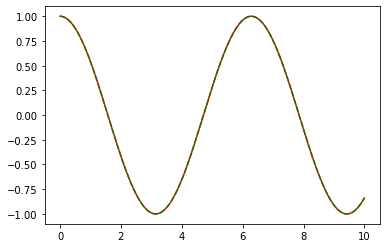

In [86]:
# Plot data from tests
data = details["Method3212"][-1]
plt.plot(data[3], data[1], 'r-', data[3], data[2], 'g--')

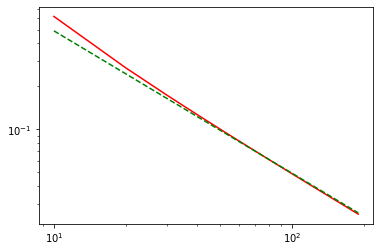

In [58]:
plt.loglog(n, res["Euler"], 'r-', n, [4.9*k**(-1) for k in n], 'g--')

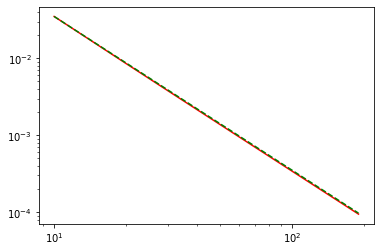

In [63]:
plt.loglog(n, res["Method3212"], 'r-', n, [3.5*k**(-2) for k in n], 'g--')

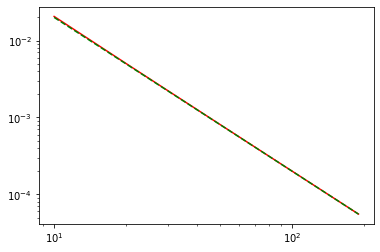

In [67]:
plt.loglog(n, res["AdamsBashford5"], 'r-', n, [2*k**(-2) for k in n], 'g--')

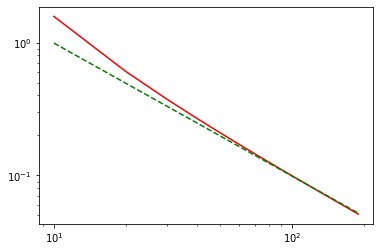

In [73]:
plt.loglog(n, res["AdamsMoulton5"], 'r-', n, [9.9*k**(-1) for k in n], 'g--')

### TEST 4 (correctness)

In [74]:
k = 1
r = 100
sim = test4(r=r, k=k, sps=500, method=Method3212)
sim.simulate()

v = [tv.val.y for tv in sim.balls[0].position.values]
time = np.array([tv.time for tv in sim.balls[0].position.values])
vc = r*np.cos(np.sqrt(k)*time)

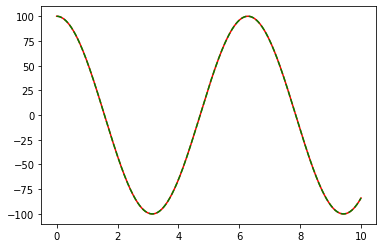

In [75]:
max_v = 5000
plt.plot(time[:max_v], v[:max_v], 'r-', time[:max_v], vc[:max_v], 'g--')

In [84]:
# Does field give correct values? (should be 1)
field = sim.fields["sinusoidal"]
field.value(Vector([0, 1]))

0.999999999999999

### Field tests

In [185]:
n = 20
samples = 50
size = 10

field_exact = lambda x, y: np.sin(x + 0.1*y**2)/(x**2+y**2+1)
field = make_field("test", size=(size, size), res=(n, n), const=True, func=lambda y, x: field_exact(x, y))

x = (np.random.random(samples)-0.5)*2*size
y = (np.random.random(samples)-0.5)*2*size
points = [Vector([x_v, y_v]) for x_v, y_v in zip(x, y)]

vals = [field.value(point) for point in points]
vals_exact = [field_exact(p.x, p.y) for p in points]
error = [abs(v - ve) for v, ve in zip(vals, vals_exact)]
relative_error = [abs(v - ve)/ve for v, ve in zip(vals, vals_exact)]

In [186]:
max(error), max(relative_error)

(0.04873867930945331, 19.90786018975908)

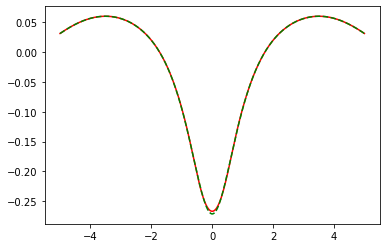

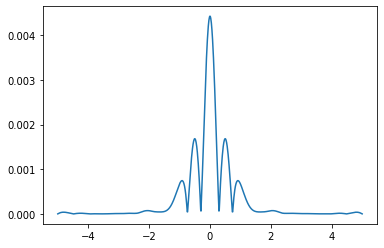

In [189]:
x = -0.3
max_y = 5
min_y = -5
p = 1000

y = np.linspace(min_y, max_y, p)
z = [field.value(Vector([x, y_v])) for y_v in y]
z_exact = field_exact(x, y)
error = [abs(z_v - ze_v) for z_v, ze_v in zip(z, z_exact)]

plt.plot(y, z, 'r-', y, z_exact, 'g--')
plt.show()
plt.plot(y, error)
plt.show()

In [159]:
@dataclass
class FieldTestResult:
    max_err: float
    points: list[Vector]
    vals: list[float]
    vals_exact: list[float]
    error: list[float]
    relative_error: list[float]
    n: int
    size: float

def test_field(func, n=20, size=10, samples=100):

    field = make_field("test", size=(size, size), res=(n, n), const=True, func= lambda y, x: func(x, y))

    x = (np.random.random(samples)-0.5)*2*size
    y = (np.random.random(samples)-0.5)*2*size
    points = [Vector([x_v, y_v]) for x_v, y_v in zip(x, y)]

    vals = [field.value(point) for point in points]
    vals_exact = [func(p.x, p.y) for p in points]
    error = [abs(v - ve) for v, ve in zip(vals, vals_exact)]
    relative_error = [abs(v - ve)/ve for v, ve in zip(vals, vals_exact)]
    
    return FieldTestResult(max_err=max(error), points=points, vals=vals, vals_exact=vals_exact, 
                           error=error, relative_error=relative_error, n=n, size=size)

In [192]:
# Convergence exponent
max_n = 400
#func = lambda y, x: np.exp(-(x-1)**2-(y-1)**2)
#func = lambda x, y: np.exp(-(x-2)**2-(y-1)**2)
func = lambda x, y: np.sin(x + 0.01*y**2)/(x**2+y**2+1)
max_value = 0.4374

tic()
n = list(range(5, max_n, 5))
res = []
details = []
_next_output = 100
_output_step = _next_output
for i in n:
    details.append(test_field(func, i, samples=2000))
    res.append(details[-1].max_err/max_value)
    if i >= _next_output:
        print(f"{i} done...")
        _next_output += _output_step
        
time = toc()

100 done...
200 done...
300 done...
Time elapsed: 18.828125


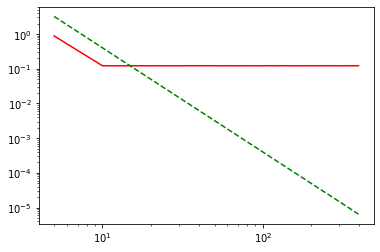

In [196]:
plt.loglog(n, res, 'r-', n, [400*k**(-3) for k in n], 'g--')#, [40], [0.0001], 'bo')

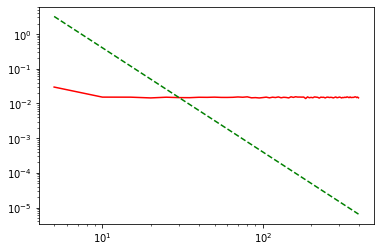

In [195]:
avg_err = [sum(d.error)/len(d.error) for d in details]
plt.loglog(n, avg_err, 'r-', n, [400*k**(-3) for k in n], 'g--')

### Other stuff

In [81]:
SimulationDisplay(test4(fres=20), fps=50, ball_radius=8).display_sim()

In [3]:
class FakeAdamsMoulton(NumStepFunc):
    
    def __init__(self, solution_func):
        super(FakeAdamsMoulton, self).__init__(req_steps=5)
        self.f = solution_func
        
    def adams_moulton_5step(self, derivatives: List[TimedVal[N]], time: float | None = None) -> N:

        if time is None:
            time = derivatives[-1].time

        last = len(derivatives) - 2
        for i in range(len(derivatives) - 1):
            if derivatives[-i - 2].time < time <= derivatives[-i - 1].time:
                last = i
                break

        if len(derivatives) - last < self.required_steps + 1:
            return self.f(time)#*(derivatives[-last-1].time - derivatives[-last-2].time)

        p4 = derivatives[-last-1]
        p3 = derivatives[-last-2]
        p2 = derivatives[-last-3]
        p1 = derivatives[-last-4]
        p0 = derivatives[-last-5]
        dt = (p4.time - p3.time)

        return dt * ((251 * p4.val + 646 * p3.val - 264 * p2.val + 106 * p1.val - 19 * p0.val) * (1/720))

    def __call__(self, derivatives: List[TimedVal[N]], time: float | None = None) -> N:
        return self.adams_moulton_5step(derivatives, time)

In [4]:
def test3_1(v=50, r=100, k=1, sps=100):

    position=PrimaryDataNumeric(Vector,
                                initial=r*Vector([0, -1]) + Vector([-300, 0]),
                                initial_derivative=v*Vector([1, 0]),
                                zero=lambda: Vector(2),
                                step_func=AdamsMoulton5())
    velocity=PrimaryDataNumeric(Vector,
                                initial=v*Vector([1, 0]),
                                zero=lambda: Vector(2),
                                step_func=AdamsMoulton5())
    
    for i in range(1, 6):
        t = i*(1/sps)
        position.derivatives.append(TimedVal(time=t, val=r*np.sin(t)*Vector([0, 1])))
        position.values.append(TimedVal(time=t, val=-r*np.cos(t)*Vector([0, 1]) + Vector([-300, 0])))
        velocity.derivatives.append(TimedVal(time=t, val=r*np.cos(t)*Vector([0, 1])))
        velocity.values.append(TimedVal(time=t, val=r*np.sin(t)*Vector([0, 1]) + v*Vector([1, 0])))
    position.f = position._make_func()
    velocity.f = velocity._make_func()

    sim = Simulation(
        start_balls=[
            Ball(position=position, velocity=velocity)
        ],
        fields={},
        interactions=[Interaction("sinusoidal", ("Ball", "border field"),
                                  formula=lambda target, _:
                                  k * target[0].position.current.y * Vector([0, -1]),
                                  attribute="velocity"
                                  )],
        start_time=t, total_time=10, steps_per_second=sps, field_size=(1000, 600))
    
    return sim